In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import random # for splitting the dataset randomly

In [2]:
DATA_DIR = "data/stanford_dogs/Images"
OUTPUT_DIR = "data/Processed"
IMG_SIZE = (224, 224)

In [3]:
def load_dataset(data_dir):
    all_paths = glob(os.path.join(data_dir, "*", "*.jpg"))
    all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    return all_paths, all_labels

# image_paths, labels = load_dataset(DATA_DIR)
# print(f"Found {len(image_paths)} images")

In [4]:
def resize_image(image, target_size=IMG_SIZE):
    """Resize the image to the target size."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

In [5]:
def normalize_image(image):
    """Normalize image pixel values to the range [0.0, 1.0]."""
    return image.astype(np.float32) / 255.0

In [6]:

def preprocess_image(path,
                     target_size=IMG_SIZE,
                     to_rgb=True,
                     normalize=True):
    """
    Load and preprocess an image from a given path:
    1) Read image file
    2) Convert BGR to RGB (if enabled)
    3) Resize to target size
    4) Normalize pixel values (if enabled)
    Returns the processed image or None if loading fails.
    """
    img = cv2.imread(path)
    if img is None:
        return None

    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = resize_image(img, target_size)

    if normalize:
        img = normalize_image(img)

    return img

In [7]:
import torch
from torchvision import transforms

# Custom Gaussian noise transform
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Final augmentation transform
final_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=0.05),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean, std)
])


In [8]:
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# for path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
#     image = cv2.imread(path)
#     if image is None:
#         continue
    
#      image = resize_image(image)
#      image = normalize_image(image)
#      image = preprocess_image(image)
    
#     save_path = os.path.join(OUTPUT_DIR, label)
#     os.makedirs(save_path, exist_ok=True)
#     filename = os.path.basename(path)
    
#     save_img = (np.clip(image, 0, 1) * 255).astype(np.uint8)
#     cv2.imwrite(os.path.join(save_path, filename), save_img)
if __name__ == "__main__":
    image_paths, labels = load_dataset(DATA_DIR)
    print(f"Found {len(image_paths)} images")

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Split the ratios:these are the ratios used for 
    # how much each dataset
    SPLIT_RATIOS = {
        "train": 0.7,
        "validation": 0.15,
        "test": 0.15
    }

    # Group paths by class, this ensures that each data split of train test and validation
    # contains examples of all breeds
    class_to_paths = {}
    
    for path, label in zip(image_paths, labels):
        if label not in class_to_paths:
           class_to_paths[label] = [] 
        class_to_paths[label].append(path)

    # assign each path to a split
    path_to_split = {}
    for label, paths in class_to_paths.items(): #for each dogbreed, get all its images
        # randomize the images going into each one by shuffling
        random.shuffle(paths)
        total = len(paths)
        train_end = int(SPLIT_RATIOS["train"] * total)
        val_end = train_end + int(SPLIT_RATIOS["validation"] * total)

        for i, path in enumerate(paths):
            if i < train_end:
                path_to_split[path] = "train"
            elif i < val_end:
                path_to_split[path] = "validation"
            else: #not in train or validation
                path_to_split[path] = "test"
                  

    # Create folders to sepearate train,test,validation data
    for split in SPLIT_RATIOS.keys():
        for label in class_to_paths:
            os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)            

    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths),
                            desc="Preprocessing"):
        img = preprocess_image(path)
        if img is None:
            print(f"[READ FAIL] {path}")  # Warn if the image could not be read
            continue

        # Convert back to 0–255 and RGB→BGR before saving
        save_img = (img * 255).astype(np.uint8)
        save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)

        split = path_to_split.get(path, "train")
        save_dir = os.path.join(OUTPUT_DIR, split, label)
        os.makedirs(save_dir, exist_ok=True)

        cv2.imwrite(os.path.join(save_dir, os.path.basename(path)), save_img)

Found 20580 images


Preprocessing:   0%|          | 0/20580 [00:00<?, ?it/s]

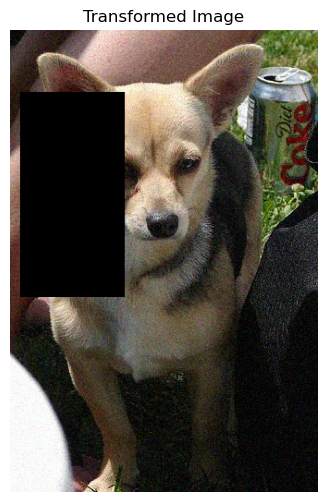

In [ ]:
# This cell is to test noise-normalization part

# from PIL import Image
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F

# # Pick a sample image path
# sample_path = image_paths[0]  # or any valid index

# # Load with OpenCV, convert BGR to RGB
# img_cv2 = cv2.imread(sample_path)
# img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# # Convert NumPy image to PIL image
# img_pil = Image.fromarray(img_rgb)

# # Apply the final transform (returns a tensor)
# img_tensor = final_transform(img_pil)

# # Convert tensor to NumPy image for visualization
# img_np = img_tensor.permute(1, 2, 0).numpy()  # CHW to HWC

# # Unnormalize for display
# img_np = (img_np * std + mean).clip(0, 1)

# # Display
# plt.figure(figsize=(6, 6))
# plt.imshow(img_np)
# plt.axis('off')
# plt.title("Transformed Image")
# plt.show()
